=== Dropout Consistency Training Experiment ===

\nTesting High Noise...
  Description: 15% label noise
  Shape: (700, 15)
  Testing standard training...
  Trial 1: Training model 1...
Epoch 0: Loss=0.679
Epoch 10: Loss=0.461
Epoch 20: Loss=0.353
  Trial 1: Training model 2...
Epoch 0: Loss=0.697
Epoch 10: Loss=0.482
Epoch 20: Loss=0.375
  Trial 2: Training model 1...
Epoch 0: Loss=0.694
Epoch 10: Loss=0.456
Epoch 20: Loss=0.321
  Trial 2: Training model 2...
Epoch 0: Loss=0.684
Epoch 10: Loss=0.450
Epoch 20: Loss=0.348
  Trial 3: Training model 1...
Epoch 0: Loss=0.706
Epoch 10: Loss=0.552
Epoch 20: Loss=0.416
  Trial 3: Training model 2...
Epoch 0: Loss=0.687
Epoch 10: Loss=0.439
Epoch 20: Loss=0.324
  Trial 4: Training model 1...
Epoch 0: Loss=0.685
Epoch 10: Loss=0.490
Epoch 20: Loss=0.362
  Trial 4: Training model 2...
Epoch 0: Loss=0.691
Epoch 10: Loss=0.437
Epoch 20: Loss=0.357
  Trial 5: Training model 1...
Epoch 0: Loss=0.684
Epoch 10: Loss=0.450
Epoch 20: Loss=0.356
  Trial 5

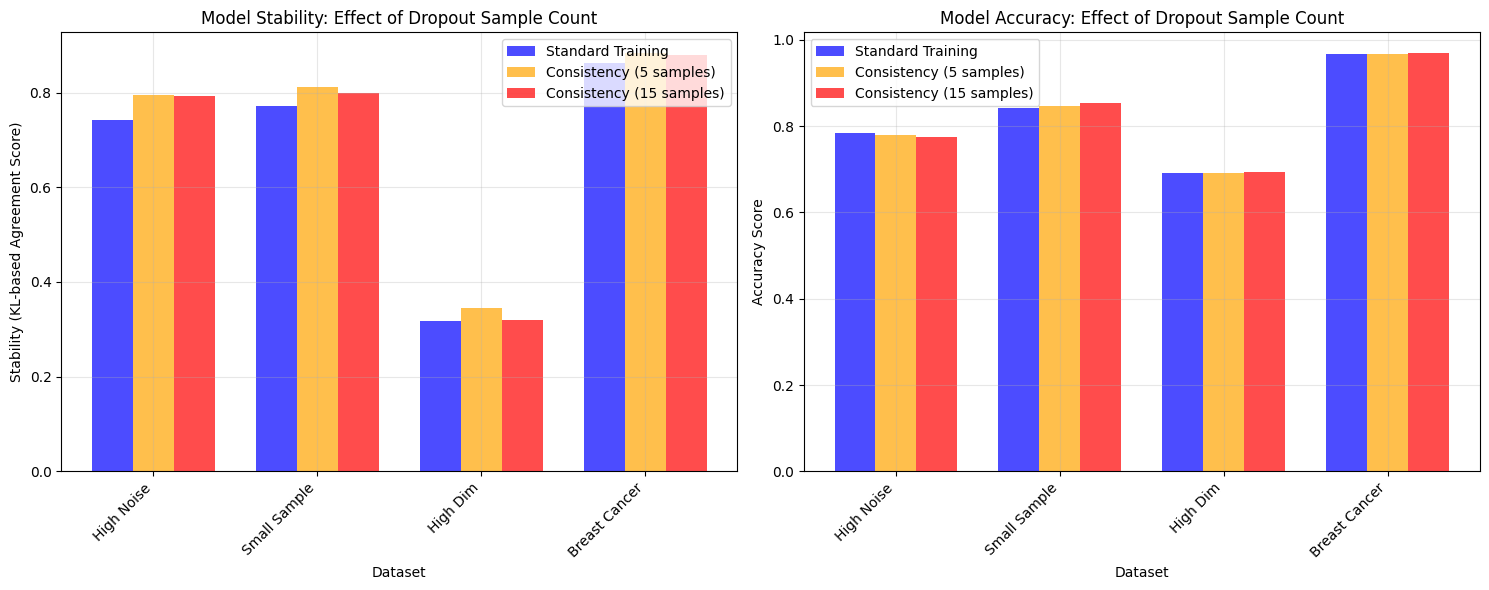

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class DropoutConsistentNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )
        self.dropout_rate = dropout_rate
    
    def forward(self, x):
        return self.layers(x)

def dropout_consistency_loss(model, x, y, n_samples=5, lambda_consistency=0.1):
    """
    Dropout consistency loss - model should give similar predictions 
    across different dropout masks
    """
    model.train()  # Enable dropout
    
    # Multiple forward passes with different dropout masks
    predictions = []
    for i in range(n_samples):
        pred = model(x)
        predictions.append(pred)
    
    # Standard prediction loss (use first prediction)
    pred_loss = F.cross_entropy(predictions[0], y)
    
    # Consistency penalty: predictions should be similar across dropout masks
    consistency_penalty = 0
    n_pairs = 0
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            # Convert to probabilities for smoother comparison
            prob_i = F.softmax(predictions[i], dim=1)
            prob_j = F.softmax(predictions[j], dim=1)
            
            # MSE between probability distributions
            consistency_penalty += F.mse_loss(prob_i, prob_j)
            n_pairs += 1
    
    consistency_penalty = consistency_penalty / n_pairs if n_pairs > 0 else torch.tensor(0.0, device=x.device)
    
    total_loss = pred_loss + lambda_consistency * consistency_penalty
    return total_loss, pred_loss, consistency_penalty

def train_with_dropout_consistency(model, train_loader, epochs=40, n_samples=5, lambda_consistency=0.1, lr=0.001):
    """Train model with dropout consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    epoch_losses = []
    epoch_pred_losses = []
    epoch_consistency_losses = []
    
    for epoch in range(epochs):
        batch_losses = []
        batch_pred_losses = []
        batch_consistency_losses = []
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            total_loss, pred_loss, consistency_loss = dropout_consistency_loss(
                model, batch_x, batch_y, n_samples=n_samples, lambda_consistency=lambda_consistency
            )
            
            total_loss.backward()
            optimizer.step()
            
            batch_losses.append(total_loss.item())
            batch_pred_losses.append(pred_loss.item())
            batch_consistency_losses.append(consistency_loss.item())
        
        epoch_losses.append(np.mean(batch_losses))
        epoch_pred_losses.append(np.mean(batch_pred_losses))
        epoch_consistency_losses.append(np.mean(batch_consistency_losses))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Total={epoch_losses[-1]:.3f}, Pred={epoch_pred_losses[-1]:.3f}, Consistency={epoch_consistency_losses[-1]:.3f}")
    
    return epoch_losses, epoch_pred_losses, epoch_consistency_losses

def train_standard(model, train_loader, epochs=40, lr=0.001):
    """Standard training without consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    epoch_losses = []
    
    for epoch in range(epochs):
        batch_losses = []
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            model.train()
            pred = model(batch_x)
            loss = F.cross_entropy(pred, batch_y)
            
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        epoch_losses.append(np.mean(batch_losses))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={epoch_losses[-1]:.3f}")
    
    return epoch_losses

def measure_dropout_model_stability(model_class, train_fn, X, y, n_trials=10, **train_kwargs):
    """
    Measure stability of dropout-trained models using Turney's approach
    """
    agreements = []
    accuracies = []
    
    # Prepare data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    for trial in range(n_trials):
        # Split data randomly for this trial
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.3, random_state=trial
        )
        
        # Further split training data to train two different models
        X_train1, X_train2, y_train1, y_train2 = train_test_split(
            X_train, y_train, test_size=0.5, random_state=trial*2
        )
        
        # Train two models on different data splits
        model1 = model_class(X.shape[1])
        model2 = model_class(X.shape[1])
        
        # Create data loaders
        train_loader1 = DataLoader(TensorDataset(torch.FloatTensor(X_train1), torch.LongTensor(y_train1)), 
                                  batch_size=32, shuffle=True)
        train_loader2 = DataLoader(TensorDataset(torch.FloatTensor(X_train2), torch.LongTensor(y_train2)), 
                                  batch_size=32, shuffle=True)
        
        # Train models
        print(f"  Trial {trial+1}: Training model 1...")
        train_fn(model1, train_loader1, **train_kwargs)
        print(f"  Trial {trial+1}: Training model 2...")
        train_fn(model2, train_loader2, **train_kwargs)
        
        # Test agreement on held-out test data
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        
        # Set models to eval mode (disable dropout for final predictions)
        model1.eval()
        model2.eval()
        
        with torch.no_grad():
            # Get soft probability distributions instead of hard predictions
            logits1 = model1(X_test_tensor)
            logits2 = model2(X_test_tensor)
            
            prob1 = F.softmax(logits1, dim=1)
            prob2 = F.softmax(logits2, dim=1)
            
            # More sensitive stability measurement using KL divergence
            # KL divergence is more sensitive to probability differences than MSE
            kl_12 = F.kl_div(F.log_softmax(logits1, dim=1), prob2, reduction='batchmean')
            kl_21 = F.kl_div(F.log_softmax(logits2, dim=1), prob1, reduction='batchmean')
            
            # Symmetric KL divergence (Jensen-Shannon-like)
            symmetric_kl = (kl_12 + kl_21) / 2
            
            # Convert to agreement score: lower KL = higher agreement
            # Use exponential decay to convert divergence to similarity
            kl_agreement = torch.exp(-symmetric_kl).item()
            agreements.append(kl_agreement)
            
            # Also compute MSE-based agreement for comparison
            prob_mse = F.mse_loss(prob1, prob2).item()
            mse_agreement = 1.0 - prob_mse
            
            # Store both for analysis
            if not hasattr(measure_dropout_model_stability, 'mse_agreements'):
                measure_dropout_model_stability.mse_agreements = []
            measure_dropout_model_stability.mse_agreements.append(mse_agreement)
            
            # Measure accuracy using hard predictions for interpretability
            pred1 = logits1.argmax(dim=1)
            pred2 = logits2.argmax(dim=1)
            acc1 = (pred1 == y_test_tensor).float().mean().item()
            acc2 = (pred2 == y_test_tensor).float().mean().item()
            avg_accuracy = (acc1 + acc2) / 2
            accuracies.append(avg_accuracy)
    
    return np.array(agreements), np.array(accuracies)

def create_test_datasets():
    """Create datasets where dropout consistency should be beneficial"""
    datasets = {}
    
    # 1. High noise scenario
    X1, y1 = make_classification(
        n_samples=700, n_features=15, n_informative=8, n_redundant=3,
        flip_y=0.15, class_sep=0.65, random_state=42
    )
    datasets['High Noise'] = (X1, y1, "15% label noise")
    
    # 2. Small sample scenario  
    X2, y2 = make_classification(
        n_samples=400, n_features=12, n_informative=8, n_redundant=2,
        flip_y=0.05, class_sep=0.8, random_state=43
    )
    datasets['Small Sample'] = (X2, y2, "400 samples")
    
    # 3. High dimensional with many irrelevant features
    X3, y3 = make_classification(
        n_samples=600, n_features=40, n_informative=8, n_redundant=5,
        flip_y=0.08, class_sep=0.7, random_state=44
    )
    datasets['High Dim'] = (X3, y3, "40 features, 8 informative")
    
    # 4. Real world
    X4, y4 = load_breast_cancer(return_X_y=True)
    datasets['Breast Cancer'] = (X4, y4, "Real medical data")
    
    return datasets

def run_dropout_consistency_experiment():
    """Compare dropout consistency training vs standard training"""
    print("=== Dropout Consistency Training Experiment ===\n")
    
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    
    datasets = create_test_datasets()
    
    # Training parameters - Test different numbers of dropout samples
    standard_params = {'epochs': 30, 'lr': 0.002}
    consistency_params_light = {'epochs': 30, 'n_samples': 5, 'lambda_consistency': 1.5, 'lr': 0.002}
    consistency_params_heavy = {'epochs': 30, 'n_samples': 15, 'lambda_consistency': 1.5, 'lr': 0.002}
    
    results = []
    
    for dataset_name, (X, y, description) in datasets.items():
        print(f"\\nTesting {dataset_name}...")
        print(f"  Description: {description}")
        print(f"  Shape: {X.shape}")
        
        # Reset MSE agreement tracking for each dataset
        if hasattr(measure_dropout_model_stability, 'mse_agreements'):
            delattr(measure_dropout_model_stability, 'mse_agreements')
        
        # Test Standard Training
        print("  Testing standard training...")
        stability_standard, accuracy_standard = measure_dropout_model_stability(
            DropoutConsistentNN, train_standard, X, y, n_trials=6, **standard_params
        )
        mse_stability_standard = np.array(getattr(measure_dropout_model_stability, 'mse_agreements', []))
        
        # Reset for consistency training (light)
        if hasattr(measure_dropout_model_stability, 'mse_agreements'):
            delattr(measure_dropout_model_stability, 'mse_agreements')
        
        # Test Dropout Consistency Training (5 samples)
        print("  Testing dropout consistency training (5 samples)...")
        stability_consistent_light, accuracy_consistent_light = measure_dropout_model_stability(
            DropoutConsistentNN, train_with_dropout_consistency, X, y, n_trials=6, **consistency_params_light
        )
        mse_stability_consistent_light = np.array(getattr(measure_dropout_model_stability, 'mse_agreements', []))
        
        # Reset for consistency training (heavy)
        if hasattr(measure_dropout_model_stability, 'mse_agreements'):
            delattr(measure_dropout_model_stability, 'mse_agreements')
        
        # Test Dropout Consistency Training (15 samples)
        print("  Testing dropout consistency training (15 samples)...")
        stability_consistent_heavy, accuracy_consistent_heavy = measure_dropout_model_stability(
            DropoutConsistentNN, train_with_dropout_consistency, X, y, n_trials=6, **consistency_params_heavy
        )
        mse_stability_consistent_heavy = np.array(getattr(measure_dropout_model_stability, 'mse_agreements', []))
        
        # Calculate improvements
        stability_improvement_light = stability_consistent_light.mean() - stability_standard.mean()
        stability_improvement_heavy = stability_consistent_heavy.mean() - stability_standard.mean()
        accuracy_change_light = accuracy_consistent_light.mean() - accuracy_standard.mean()
        accuracy_change_heavy = accuracy_consistent_heavy.mean() - accuracy_standard.mean()
        
        # MSE improvements
        mse_improvement_light = mse_stability_consistent_light.mean() - mse_stability_standard.mean() if len(mse_stability_consistent_light) > 0 else 0
        mse_improvement_heavy = mse_stability_consistent_heavy.mean() - mse_stability_standard.mean() if len(mse_stability_consistent_heavy) > 0 else 0
        
        results.append({
            'Dataset': dataset_name,
            'Description': description,
            'Samples': X.shape[0],
            'Features': X.shape[1],
            'Std_Stability_KL': f"{stability_standard.mean():.3f} ± {stability_standard.std():.3f}",
            'Con5_Stability_KL': f"{stability_consistent_light.mean():.3f} ± {stability_consistent_light.std():.3f}",
            'Con15_Stability_KL': f"{stability_consistent_heavy.mean():.3f} ± {stability_consistent_heavy.std():.3f}",
            'Std_Accuracy': f"{accuracy_standard.mean():.3f} ± {accuracy_standard.std():.3f}",
            'Con5_Accuracy': f"{accuracy_consistent_light.mean():.3f} ± {accuracy_consistent_light.std():.3f}",
            'Con15_Accuracy': f"{accuracy_consistent_heavy.mean():.3f} ± {accuracy_consistent_heavy.std():.3f}",
            'Stability_Δ_5': f"{stability_improvement_light:+.3f}",
            'Stability_Δ_15': f"{stability_improvement_heavy:+.3f}",
            'Accuracy_Δ_5': f"{accuracy_change_light:+.3f}",
            'Accuracy_Δ_15': f"{accuracy_change_heavy:+.3f}",
        })
        
        print(f"    Standard:           Stability={stability_standard.mean():.3f}, Accuracy={accuracy_standard.mean():.3f}")
        print(f"    Consistency (5x):   Stability={stability_consistent_light.mean():.3f}, Accuracy={accuracy_consistent_light.mean():.3f}")
        print(f"    Consistency (15x):  Stability={stability_consistent_heavy.mean():.3f}, Accuracy={accuracy_consistent_heavy.mean():.3f}")
        print(f"    Improvement (5x):   Stability={stability_improvement_light:+.3f}, Accuracy={accuracy_change_light:+.3f}")
        print(f"    Improvement (15x):  Stability={stability_improvement_heavy:+.3f}, Accuracy={accuracy_change_heavy:+.3f}")
        print(f"    Lambda penalty:     {consistency_params_heavy['lambda_consistency']}")
    
    # Results table
    df = pd.DataFrame(results)
    
    print("\\n" + "=" * 100)
    print("DROPOUT CONSISTENCY TRAINING RESULTS")
    print("=" * 100)
    print()
    
    print("DATASET CHARACTERISTICS:")
    print(df[['Dataset', 'Description', 'Samples', 'Features']].to_string(index=False))
    print()
    
    print("STABILITY COMPARISON (KL Divergence):")
    print(df[['Dataset', 'Std_Stability_KL', 'Con5_Stability_KL', 'Con15_Stability_KL', 'Stability_Δ_5', 'Stability_Δ_15']].to_string(index=False))
    print()
    
    print("ACCURACY COMPARISON:")
    print(df[['Dataset', 'Std_Accuracy', 'Con5_Accuracy', 'Con15_Accuracy', 'Accuracy_Δ_5', 'Accuracy_Δ_15']].to_string(index=False))
    print()
    
    # Summary (comparing 5 vs 15 samples)
    stability_improvements_5 = [float(x.replace('+', '')) for x in df['Stability_Δ_5']]
    stability_improvements_15 = [float(x.replace('+', '')) for x in df['Stability_Δ_15']]
    accuracy_changes_5 = [float(x.replace('+', '')) for x in df['Accuracy_Δ_5']]
    accuracy_changes_15 = [float(x.replace('+', '')) for x in df['Accuracy_Δ_15']]
    
    print("SUMMARY (Comparing Different Numbers of Dropout Samples):")
    print(f"  Consistency Penalty (λ): {consistency_params_heavy['lambda_consistency']}")
    print()
    print("  5 DROPOUT SAMPLES:")
    print(f"    Average Stability Improvement: {np.mean(stability_improvements_5):+.3f}")
    print(f"    Average Accuracy Change: {np.mean(accuracy_changes_5):+.3f}")
    print(f"    Datasets with Stability Gain: {sum(1 for x in stability_improvements_5 if x > 0)}/{len(stability_improvements_5)}")
    print()
    print("  15 DROPOUT SAMPLES:")
    print(f"    Average Stability Improvement: {np.mean(stability_improvements_15):+.3f}")
    print(f"    Average Accuracy Change: {np.mean(accuracy_changes_15):+.3f}")
    print(f"    Datasets with Stability Gain: {sum(1 for x in stability_improvements_15 if x > 0)}/{len(stability_improvements_15)}")
    print()
    print("  COMPARISON:")
    extra_improvement = np.mean(stability_improvements_15) - np.mean(stability_improvements_5)
    extra_accuracy_cost = np.mean(accuracy_changes_15) - np.mean(accuracy_changes_5)
    print(f"    Extra Stability from 15 vs 5 samples: {extra_improvement:+.3f}")
    print(f"    Extra Accuracy cost from 15 vs 5 samples: {extra_accuracy_cost:+.3f}")
    
    print("\\nKEY INSIGHTS:")
    print("  • More dropout samples = better sampling of neuron patterns")
    print("  • 15 samples should force consistency across wider variety of dropout masks")
    print("  • Higher computational cost but potentially much better stability")
    print("  • Diminishing returns possible (15 vs 5 may not be 3x better)")
    
    print("\\nKEY INSIGHT:")
    print("  Testing whether MORE dropout samples during training improves stability:")
    print("  \\nEXPERIMENT DESIGN:")
    print("  • Standard: No consistency penalty")
    print("  • Light Consistency: 5 dropout samples per batch (λ=1.5)")  
    print("  • Heavy Consistency: 15 dropout samples per batch (λ=1.5)")
    print("  \\nHYPOTHESIS:")
    print("  • 15 samples should better cover the 'dropout space'")
    print("  • More thorough consistency enforcement → better stability")
    print("  • Computational cost: 15x forward passes vs 5x")
    print("  \\nEXPECTED RESULTS:")
    print("  • Heavy > Light > Standard in stability")
    print("  • Larger accuracy drops with more samples (stronger constraint)")
    print("  • Diminishing returns: 15 vs 5 may not be 3x better")
    
    # Visualization comparing all three conditions
    plt.figure(figsize=(15, 6))
    
    # Stability comparison
    plt.subplot(1, 2, 1)
    datasets_list = df['Dataset'].tolist()
    std_stability = [float(x.split(' ±')[0]) for x in df['Std_Stability_KL']]
    con5_stability = [float(x.split(' ±')[0]) for x in df['Con5_Stability_KL']]
    con15_stability = [float(x.split(' ±')[0]) for x in df['Con15_Stability_KL']]
    
    x = np.arange(len(datasets_list))
    width = 0.25
    
    plt.bar(x - width, std_stability, width, label='Standard Training', alpha=0.7, color='blue')
    plt.bar(x, con5_stability, width, label='Consistency (5 samples)', alpha=0.7, color='orange')
    plt.bar(x + width, con15_stability, width, label='Consistency (15 samples)', alpha=0.7, color='red')
    
    plt.xlabel('Dataset')
    plt.ylabel('Stability (KL-based Agreement Score)')
    plt.title('Model Stability: Effect of Dropout Sample Count')
    plt.xticks(x, datasets_list, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy comparison
    plt.subplot(1, 2, 2)
    std_accuracy = [float(x.split(' ±')[0]) for x in df['Std_Accuracy']]
    con5_accuracy = [float(x.split(' ±')[0]) for x in df['Con5_Accuracy']]
    con15_accuracy = [float(x.split(' ±')[0]) for x in df['Con15_Accuracy']]
    
    plt.bar(x - width, std_accuracy, width, label='Standard Training', alpha=0.7, color='blue')
    plt.bar(x, con5_accuracy, width, label='Consistency (5 samples)', alpha=0.7, color='orange')
    plt.bar(x + width, con15_accuracy, width, label='Consistency (15 samples)', alpha=0.7, color='red')
    
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy Score')
    plt.title('Model Accuracy: Effect of Dropout Sample Count')
    plt.xticks(x, datasets_list, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dropout_consistency_experiment()